[TODO]: About Mnist

In [1]:
from core.utils import Utils

device = Utils.select_cuda_device('cpu')

## Creating the data lodaers

In [2]:
from core.dataLoaders.fashion_mnist import Fashion_MNIST
import torch
import torchvision.transforms as T

torch.manual_seed(22)

transform = T.Compose([
    T.ToTensor(), 
    # T.Lambda(lambda x: torch.flatten(x))
])

data_cls = Fashion_MNIST(transforms=transform)

# create data loader
[train_loader, test_loader] = data_cls.create_loader()

train_data_sample_shape  = data_cls.view_sample_stats()
print(train_data_sample_shape)

/Users/srrthk/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/srrthk/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/srrthk/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <13D54172-DB68-3BCA-9DFD-9BABA030E1E4> /Users/srrthk/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(



------------- Train Stats --------------

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64

------------- test Stats  --------------

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64

-------------    END      ---------------

torch.Size([64, 1, 28, 28])


## Initilaizing Model

In [3]:
train_data_sample_shape[0]

64

In [4]:
from core.models.fvsbn import FVSBN

model = FVSBN(train_data_sample_shape[2]*train_data_sample_shape[3], device)
print(model)

FVSBN(
  (sigmoid): Sigmoid()
)


In [5]:
import torch.nn as nn
import torch
# Define the loss function
criterion = nn.BCELoss(reduction='sum')

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training Loop

Epoch 30, Log Likelihood: 50355.8515625
Epoch 30 Generating samples from the model
Epoch 40, Log Likelihood: 93199.921875
Epoch 50, Log Likelihood: 141418.8125
Epoch 60, Log Likelihood: 195534.078125
Epoch 60 Generating samples from the model
Epoch 70, Log Likelihood: 256349.234375
Epoch 80, Log Likelihood: 324889.03125
Epoch 90, Log Likelihood: 399995.40625
Epoch 90 Generating samples from the model
Epoch 100, Log Likelihood: 478356.9375
NaN detected in log-likelihoods at epoch 105. Stopping training.


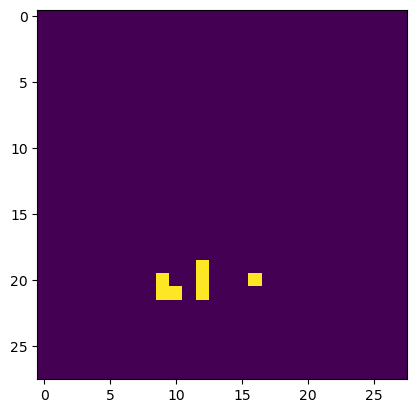

In [6]:
from tqdm import tqdm
import matplotlib.pyplot as plt

st_epochs = 21
epochs = 400
# Training 
# tr_bar = tqdm(list(range(epochs)))
ep_loss = []
test_loss = []
model_saturated = False
for epoch in range(st_epochs,epochs):
    for images, _ in train_loader:
        images = images.view(images.size(0), -1)
        log_likelihoods = model(images.to(device))# we want to maximize the probability
        loss = -log_likelihoods
        loss.backward()
        optimizer.step()
    # Check for NaN in log-likelihoods
        if torch.isnan(log_likelihoods).any():
            print(f"NaN detected in log-likelihoods at epoch {epoch+1}. Stopping training.")
            model_saturated = True
            break
    if model_saturated:
        break
    if (epoch+1)%10 == 0:
        loss = loss.item()
        ep_loss.append(loss)
        print(f'Epoch {epoch+1}, Log Likelihood: {log_likelihoods.item()}')
    if (epoch+1)%30 == 0:
        print(f'Epoch {epoch+1} Generating samples from the model')
        x = model.sample(2)
        # x.nansum()
        x = x.view(2, 28,28)
        plt.imshow(x[0])
        plt.imshow(x[1])


### Important Observations

While training the model, we can see that the model is learning the data distribution by the log likelihoods at every 10 epochs

### Sampling from model by giving half the data

In [16]:
# Save the model state at this point
torch.save(model.state_dict(), f'model_dump/model_{epoch+1}.pt')

In [ ]:
import torch.distributions as dist

def sample_img(model, x):
    bernoulli_mean_dim = torch.sigmoid(x.matmul(model.weights)+model.bias)
    bernoulli_mean_dim = bernoulli_mean_dim.nan_to_num(0)
    distribution = dist.bernoulli.Bernoulli(probs=bernoulli_mean_dim)
    x = distribution.sample()
    return x

# Testing the model by giving half the image and predicting the other half
for i, (images, _) in enumerate(test_loader):
    for img in images:
        plt.imshow(img.view(28,28).cpu().numpy())
        plt.show()
        img = img.view(img.size(0), -1)
        mask = torch.ones_like(img)
        mask[:, :int(img.shape[1]//2)] = 0
        img = img*mask
        img = sample_img(model, img)
        img = img.view(img.size(0), 28,28)
        # plt.imshow(img[0])
        # plt.show()
    # break
print(mask.shape)
# mask[:,:,]

In [9]:
# Drawing Samples from the model and plotting them
model.sample(2)

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

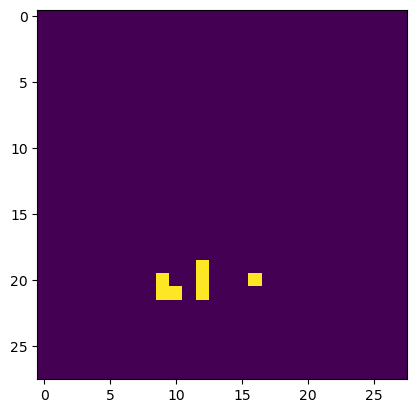

In [10]:
# resize the sample to 28,28 and plot it
import torch.distributions as dist

x = model.sample(2)
x = x.view(2, 28,28)
# plt.imshow(x)
plt.imshow(x[0])
plt.imshow(x[1])



In [11]:
import torch.distributions as dist

x = torch.rand(2, 28,28)
y = dist.bernoulli.Bernoulli(probs=x)
y.sample()

tensor([[[0., 0., 0.,  ..., 0., 0., 1.],
         [1., 1., 1.,  ..., 1., 0., 1.],
         [0., 1., 1.,  ..., 1., 0., 0.],
         ...,
         [0., 1., 1.,  ..., 1., 1., 1.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.]],

        [[1., 0., 1.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [1., 0., 1.,  ..., 1., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 0.,  ..., 1., 1., 0.],
         [1., 0., 1.,  ..., 1., 0., 1.]]])

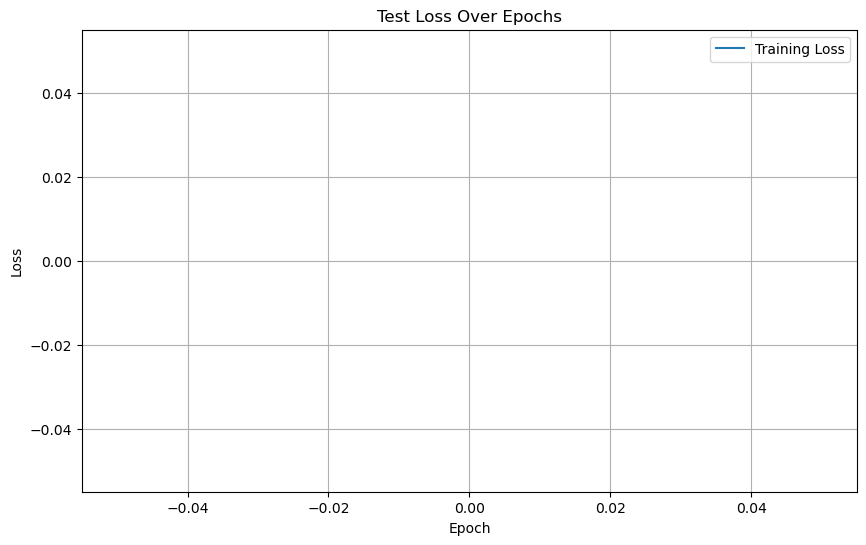

In [12]:
import matplotlib.pyplot as plt

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(test_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

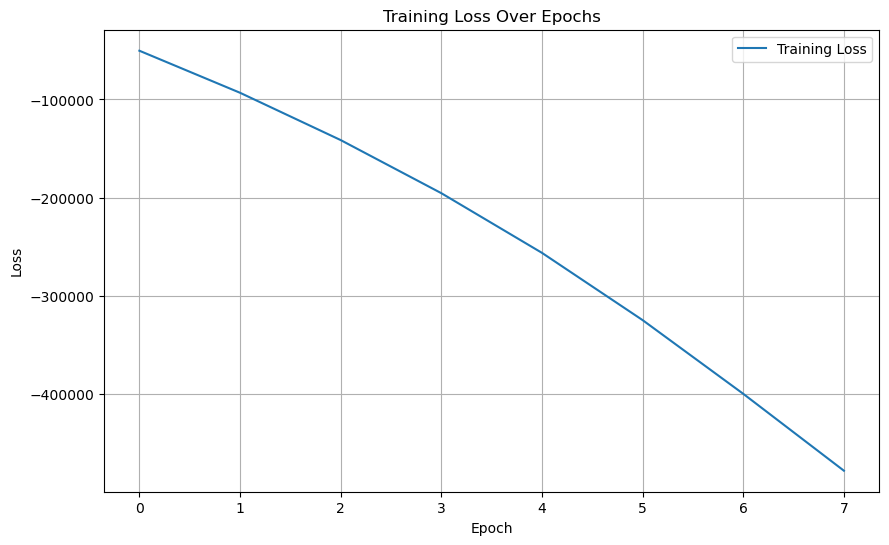

In [13]:
import matplotlib.pyplot as plt

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(ep_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Model Testing 

Higher average log likyhoods indiacet model has learnt the data distribution, conversely, lower avg log likyhoods indicate model's inability to learn the distribution

In [14]:

def test(model: FVSBN, loader):
    model.eval()  # Set the model to evaluation mode
    total_log_likelihood = 0
    num_samples = 0
    
    with torch.no_grad():
        for images, _ in loader:
            # images = images.view(-1, 784)  # Flatten the images
            # images = (images > 0.5).float()  # Binarize the images
            
            # -------- Approach 1 -------------
            # logits =  (model.weights @ images.T).T + model.biases
            # probs[:,0] = model.biases[0]
            # probs = torch.sigmoid(logits)
            # probs = torch.bernoulli(probs)
            # log_likelihood = (images * torch.log(probs + 1e-8) + (1 - images) * torch.log(1 - probs + 1e-8)).sum()
            # total_log_likelihood += log_likelihood.item()
            # num_samples += images.size(0)
            # -------- Approach 2 -------------
            # [TODO] : Check if this is correct
            images = (images > 0.5).float()  # Binarize the images
            output = torch.zeros_like(images)
            logits =  (model.weights @ images.T).T + model.biases
            output[:,0] = torch.sigmoid(model.biases[0])
            output[:,1:] = torch.sigmoid(logits[:,:-1])
            log_likelihood = (images * torch.log(output + 1e-8) + (1 - images) * torch.log(1 - output + 1e-8)).sum()
            total_log_likelihood += log_likelihood.item()
            num_samples += images.size(0)
        average_log_likelihood = total_log_likelihood / num_samples
        print(f'Average Log-Likelihood: {average_log_likelihood}, total iter => {num_samples}')
    return average_log_likelihood

In [24]:
loader = test_loader
total_log_likelihood = 0
num_samples = 0

with torch.no_grad():
    for images, _ in loader:
        images = (images > 0.5).float()  # Binarize the images
        print(images.shape)
        output = torch.zeros_like(images[:, :, :int(images.shape[1]//2)])
        
        logits =  (model.weights @ images.T).T + model.biases
        output[:,0] = torch.sigmoid(model.biases[0])
        output[:,1:] = torch.sigmoid(logits[:,:-1])
        log_likelihood = (images * torch.log(output + 1e-8) + (1 - images) * torch.log(1 - output + 1e-8)).sum()
        total_log_likelihood += log_likelihood.item()
        num_samples += images.size(0)
    # break
    average_log_likelihood = total_log_likelihood / num_samples

torch.Size([64, 1, 28, 28])


ZeroDivisionError: division by zero

In [ ]:
average_log_likelihood

ToDo: Increase the LR by ten folds and see the loss

In [ ]:
test(model, test_loader)

In [ ]:
epochs = 100

# Training 
for epoch in range(epochs):
    for images, _ in train_loader:
        optimizer.zero_grad()
        probs = model(images)
        loss = criterion(probs, images)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

In [ ]:
test(model, test_loader)

In [ ]:
for i, _ in train_loader:
    img = i[0]
    break
print(img.shape)
import matplotlib.pyplot as plt
# Convert tensor to a NumPy array
numpy_array = img.resize(28,28)
numpy_array = numpy_array.cpu().numpy()

# Plotting the tensor values
plt.figure(figsize=(10, 6))
plt.imshow(numpy_array)

In [ ]:
numpy_array